In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import timeit
from sklearn import decomposition
from sklearn import preprocessing

In [2]:
path_to_file = r'/Users/gulsumkapanoglu/Desktop/P4/'

In [3]:
energy = pd.read_csv(path_to_file + 'energy-cleaned.csv')

In [4]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1085 non-null   int64  
 1   DataYear                       1085 non-null   int64  
 2   BuildingType                   1085 non-null   object 
 3   PrimaryPropertyType            1085 non-null   object 
 4   ZipCode                        1079 non-null   float64
 5   TaxParcelIdentificationNumber  1085 non-null   object 
 6   CouncilDistrictCode            1085 non-null   int64  
 7   Neighborhood                   1085 non-null   object 
 8   NumberofBuildings              1085 non-null   float64
 9   NumberofFloors                 1085 non-null   int64  
 10  PropertyGFATotal               1085 non-null   int64  
 11  ListOfAllPropertyUseTypes      1085 non-null   object 
 12  LargestPropertyUseType         1085 non-null   o

In [5]:
def reg_met(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted")
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse)
    print("MAPE: ", mape.round(5))
    print("R²: ", r_score.round(5))

In [6]:
energy[(energy.GFAPerBuilding == np.inf) | (energy.GFAPerFloor == np.inf)].head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,...,GHGEmissionsIntensity,Âgebâtiment,out_clas,consumption_rate_Electricity,consumption_rate_Gas,consumption_rate_Steam,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor
57,89,2016,NonResidential,Medical Office,98122.0,1978201270,3,EAST,0.0,3,...,2.41,51,Low,High Usage,High Usage,Low Usage,1.00000,0.00000,inf,59671.333
144,267,2016,NonResidential,Hotel,98101.0,6792120000,7,DOWNTOWN,1.0,0,...,1.75,17,Low,High Usage,High Usage,Low Usage,1.00000,0.00000,934292.0,inf
172,322,2016,NonResidential,Large Office,98121.0,0656000005,7,DOWNTOWN,0.0,3,...,0.68,48,Low,High Usage,Low Usage,Low Usage,0.73464,0.26536,inf,33578.000
208,366,2016,NonResidential,Small- and Mid-Sized Office,98105.0,1142000500,4,NORTHEAST,0.0,5,...,1.20,55,Low,High Usage,High Usage,Low Usage,1.00000,0.00000,inf,19801.000
228,391,2016,NonResidential,Mixed Use Property,98108.0,0007400015,2,GREATER DUWAMISH,0.0,1,...,1.31,46,Low,High Usage,High Usage,Low Usage,1.00000,0.00000,inf,88400.000


In [7]:
energy['GFAPerBuilding'] = np.where(((energy.GFAPerBuilding == np.inf) & (energy.NumberofBuildings == 0)),0, energy.GFAPerBuilding)
energy['GFAPerFloor'] = np.where(((energy.GFAPerFloor == np.inf) & (energy.NumberofFloors == 0)),0, energy.GFAPerFloor)

In [8]:
numerical_features = energy.select_dtypes(include=['int64','float64'])
categorical_features = energy.select_dtypes(exclude=['int64','float64'])

In [9]:
categorical_features.nunique()

BuildingType                        4
PrimaryPropertyType                20
TaxParcelIdentificationNumber    1034
Neighborhood                       13
ListOfAllPropertyUseTypes         298
LargestPropertyUseType             50
ComplianceStatus                    2
out_clas                            1
consumption_rate_Electricity        2
consumption_rate_Gas                2
consumption_rate_Steam              2
dtype: int64

In [10]:
categorical_features = categorical_features.drop(['ComplianceStatus','out_clas'], axis=1)

In [11]:
list(numerical_features.columns)

['OSEBuildingID',
 'DataYear',
 'ZipCode',
 'CouncilDistrictCode',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUseWN(kBtu)',
 'Electricity(kWh)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'Âgebâtiment',
 'GFABuildingRate',
 'GFAParkingRate',
 'GFAPerBuilding',
 'GFAPerFloor']

In [12]:
energystar_score = numerical_features['ENERGYSTARScore']
numerical_features = numerical_features.drop(['ENERGYSTARScore','OSEBuildingID','CouncilDistrictCode','ZipCode','Electricity(kWh)','GHGEmissionsIntensity',], axis=1)

In [13]:
data_filter = pd.concat([categorical_features, numerical_features], axis=1)

In [14]:
data_filter.head()

,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,consumption_rate_Electricity,consumption_rate_Gas,consumption_rate_Steam,DataYear,...,PropertyGFATotal,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),TotalGHGEmissions,Âgebâtiment,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor
0,NonResidential,Hotel,0659000030,DOWNTOWN,Hotel,Hotel,High Usage,High Usage,High Usage,2016,...,88434,84.300003,189.000000,7456910.0,249.98,89,1.00000,0.00000,88434.0,7369.500
1,NonResidential,Hotel,0659000220,DOWNTOWN,"Hotel, Parking, Restaurant",Hotel,High Usage,High Usage,Low Usage,2016,...,103566,97.900002,179.399994,8664479.0,295.86,20,0.85455,0.14545,103566.0,9415.091
2,NonResidential,Hotel,0659000475,DOWNTOWN,Hotel,Hotel,High Usage,High Usage,High Usage,2016,...,956110,97.699997,244.100006,73937112.0,2089.28,47,0.79425,0.20575,956110.0,23319.756
3,NonResidential,Hotel,0659000640,DOWNTOWN,Hotel,Hotel,High Usage,High Usage,High Usage,2016,...,61320,113.300003,224.000000,6946800.5,286.43,90,1.00000,0.00000,61320.0,6132.000
4,NonResidential,Hotel,0659000970,DOWNTOWN,"Hotel, Parking, Swimming Pool",Hotel,High Usage,High Usage,Low Usage,2016,...,175580,118.699997,215.600006,14656503.0,505.01,36,0.64688,0.35312,175580.0,9754.444


In [15]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer

target_features = ['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType',
                   'consumption_rate_Electricity','consumption_rate_Gas','consumption_rate_Steam']
target_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

numeric_features = ['NumberofBuildings','NumberofFloors',
                    'PropertyGFATotal','Âgebâtiment','GFABuildingRate','GFAParkingRate',
                    'GFAPerBuilding','GFAPerFloor']
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('target', target_transformer, target_features),
    ('numeric', numeric_transformer, numeric_features)
])

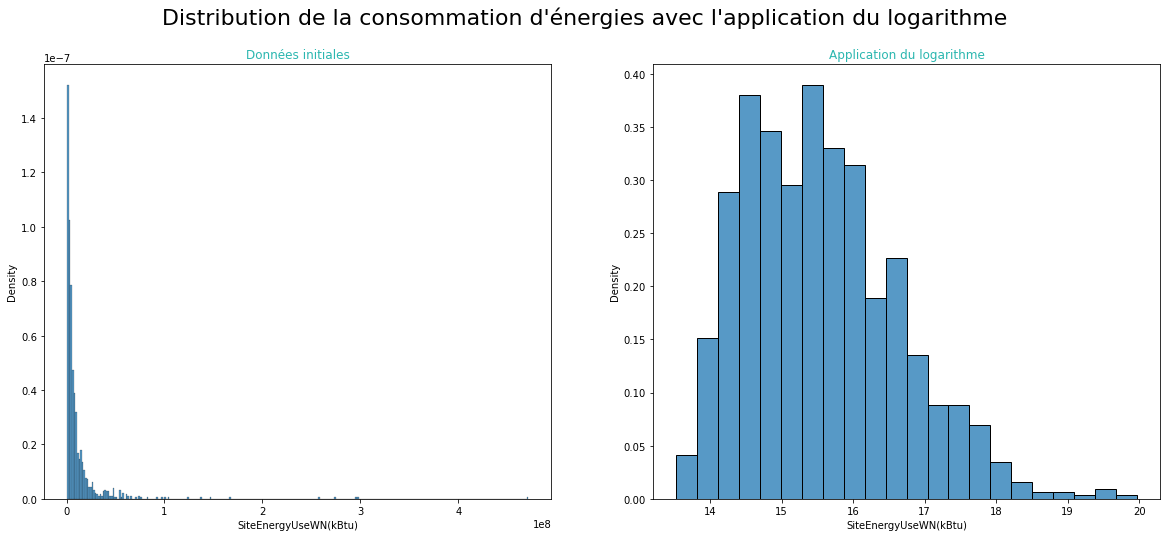

In [16]:
from sklearn.preprocessing import FunctionTransformer
Y = data_filter[["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"]]
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='SiteEnergyUseWN(kBtu)', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='SiteEnergyUseWN(kBtu)', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
plt.suptitle("Distribution de la consommation d'énergies avec l'application du logarithme",fontsize=22)
plt.show()

In [17]:
data_filter["SiteEnergyUseWN(kBtu)_log"] = np.log(data_filter["SiteEnergyUseWN(kBtu)"])
data_filter["TotalGHGEmissions_log"] = np.log(data_filter["TotalGHGEmissions"])

In [18]:
data_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   BuildingType                   1085 non-null   object 
 1   PrimaryPropertyType            1085 non-null   object 
 2   TaxParcelIdentificationNumber  1085 non-null   object 
 3   Neighborhood                   1085 non-null   object 
 4   ListOfAllPropertyUseTypes      1085 non-null   object 
 5   LargestPropertyUseType         1085 non-null   object 
 6   consumption_rate_Electricity   1085 non-null   object 
 7   consumption_rate_Gas           1085 non-null   object 
 8   consumption_rate_Steam         1085 non-null   object 
 9   DataYear                       1085 non-null   int64  
 10  NumberofBuildings              1085 non-null   float64
 11  NumberofFloors                 1085 non-null   int64  
 12  PropertyGFATotal               1085 non-null   i

In [19]:
data_filter = data_filter.drop(['TaxParcelIdentificationNumber','ListOfAllPropertyUseTypes', 'DataYear','SourceEUIWN(kBtu/sf)','SiteEUIWN(kBtu/sf)'], axis=1)

## Les Models de Prediction de la consommation d'énergie 

### D'abord on va etudie les models sans log

Tout d'abord, nous allons créer un modèle de base pour évaluer les performances des modèles que nous utiliserons et vérifier qu'ils améliorent les prédictions. 

pour cela, nous utiliserons une régression dummy comme première étape

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [21]:
from sklearn.model_selection import train_test_split

X = data_filter.drop(['TotalGHGEmissions','SiteEnergyUseWN(kBtu)',"SiteEnergyUseWN(kBtu)_log","TotalGHGEmissions_log"], axis=1)
Y = data_filter[["SiteEnergyUseWN(kBtu)"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))


Entrainement: 813 lignes,
Test: 272 lignes.



## Modèle Baseline 

In [22]:
# transformation des variables
X_train = preprocessor.fit_transform(X_train)

In [23]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, Y_train)

DummyRegressor(strategy='median')

In [24]:
# Prédiction dummy regressor
# Evaluation du modèle
X_test = preprocessor.transform(X_test)
Y_pred= dummy_reg.predict(X_test)
reg_met(np.array(Y_test), Y_pred)

MAE:  9882214.40625
MSE:  1099042288081069.1
RMSE:  33151806.70915341
MAPE:  0.98359
R²:  -0.04941


In [25]:
# examiner différents modèles de régression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso,Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

dummy_reg = DummyRegressor(strategy="median")
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
neigh = KNeighborsRegressor(n_neighbors=3)

In [26]:
#Les modèles sans paramètre spécifique
# MAE, MSE, RMSE, R²
model = [dummy_reg, lasso, ridge,  dt_reg, svm_reg, ridge_kernel, adaboost, rdmforest, gdboost,  neigh]
dict_model = {}

for model in model:
    model.fit(X_train, Y_train)
    start_time = timeit.default_timer()
    Y_pred = model.predict(X_test)
    time = timeit.default_timer() - start_time
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(Y_test, Y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score, time)

results = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²","time"])
results.columns = ["Dummy Regressor", "Lasso", "Ridge", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost","Random Forest", "GradientBoosting", "KNN"]

results

,Dummy Regressor,Lasso,Ridge,DecisionTree,SVM,Ridge Kernel,AdaBoost,Random Forest,GradientBoosting,KNN
MAE,9.882214e+06,6.921841e+06,6.986702e+06,7.039676e+06,9.882192e+06,6.991724e+06,1.684577e+07,6.014202e+06,6.131018e+06,7.031609e+06
MSE,1.099042e+15,8.500710e+14,8.527586e+14,8.720105e+14,1.099041e+15,8.535716e+14,9.216402e+14,7.234253e+14,7.554722e+14,7.880508e+14
RMSE,3.315181e+07,2.915598e+07,2.920203e+07,2.952982e+07,3.315179e+07,2.921595e+07,3.035853e+07,2.689657e+07,2.748585e+07,2.807224e+07
R²,-4.900000e-02,1.880000e-01,1.860000e-01,1.670000e-01,-4.900000e-02,1.850000e-01,1.200000e-01,3.090000e-01,2.790000e-01,2.480000e-01
time,1.338940e-04,2.340823e-03,2.113030e-04,4.138690e-04,5.639792e-02,3.836831e-03,7.455705e-03,1.377393e-02,7.919580e-04,7.438980e-03


### Examine avec au log

In [27]:
X = data_filter.drop(['TotalGHGEmissions','SiteEnergyUseWN(kBtu)',"SiteEnergyUseWN(kBtu)_log","TotalGHGEmissions_log"], axis=1)
Y = data_filter[["SiteEnergyUseWN(kBtu)_log"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [28]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, Y_train)

DummyRegressor(strategy='median')

In [29]:
Y_pred= dummy_reg.predict(X_test)
reg_met(np.array(Y_test), Y_pred)

MAE:  0.87813
MSE:  1.23705
RMSE:  1.112226078464313
MAPE:  0.05573
R²:  -0.00314


In [57]:
# examiner différents modèles de régression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso,Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

dummy_reg = DummyRegressor(strategy="median")
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
neigh = KNeighborsRegressor(n_neighbors=3)

In [58]:
#Les modèles sans paramètre spécifique
# MAE, MSE, RMSE, R²
model = [dummy_reg, lasso, ridge,  dt_reg, svm_reg, ridge_kernel, adaboost, rdmforest, gdboost,  neigh]
dict_model = {}

for model in model:
    model.fit(X_train, Y_train)
    start_time = timeit.default_timer()
    Y_pred = model.predict(X_test)
    time = timeit.default_timer() - start_time
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(Y_test, Y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score, time)

results = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²","time"])
results.columns = ["Dummy Regressor", "Lasso", "Ridge", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost","Random Forest", "GradientBoosting", "KNN"]

results

,Dummy Regressor,Lasso,Ridge,DecisionTree,SVM,Ridge Kernel,AdaBoost,Random Forest,GradientBoosting,KNN
MAE,0.878000,0.886000,0.541000,0.562000,0.443000,0.540000,0.542000,0.435000,0.448000,0.52100
MSE,1.237000,1.234000,0.643000,0.567000,0.371000,0.630000,0.438000,0.326000,0.353000,0.48500
RMSE,1.112000,1.111000,0.802000,0.753000,0.609000,0.794000,0.661000,0.571000,0.595000,0.69700
R²,-0.003000,-0.000000,0.479000,0.540000,0.699000,0.489000,0.645000,0.735000,0.713000,0.60600
time,0.000069,0.000362,0.000585,0.000449,0.052413,0.002466,0.006904,0.013172,0.000695,0.00463


In [30]:
from sklearn.preprocessing import FunctionTransformer
exptransformer = preprocessing.FunctionTransformer(np.expm1, inverse_func = np.log1p, check_inverse = True)
y_pred_dumMedexp = exptransformer.transform(Y_pred)
Y_testexp = exptransformer.transform(Y_test)

In [31]:
df=pd.DataFrame(y_pred_dumMedexp,columns=['predic'])

Text(0, 0.5, 'Les valeurs estimées')

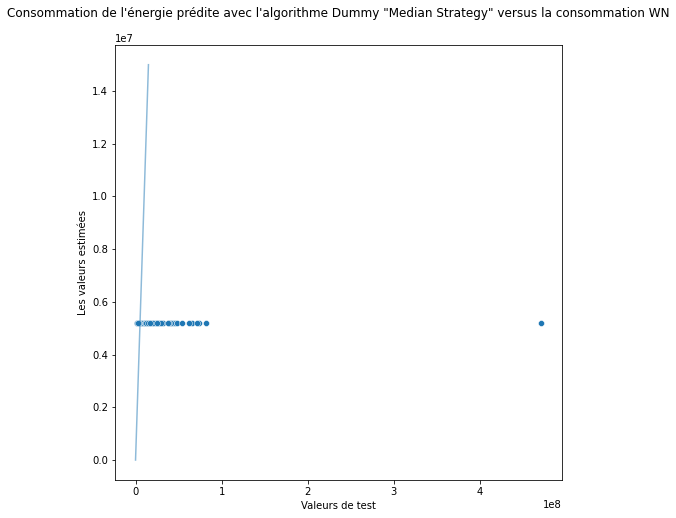

In [56]:
plt.figure(figsize=(8,8))
sns.lineplot(x = [0,1.5e7], y = [0,1.5e7], alpha=0.5)
sns.scatterplot(Y_testexp["SiteEnergyUseWN(kBtu)_log"],df["predic"])
plt.title('Consommation de l\'énergie prédite avec l\'algorithme Dummy "Median Strategy" versus la consommation WN',y=1.05)
plt.xlabel('Valeurs de test')
plt.ylabel('Les valeurs estimées')

## Recherche le meilleur modèle

On va etudier les modeles linears ; dummyregressor,LinearRegressor, Lasso, Ridge, ElasticNet, KNNRegressor,
SVR,DecisionTreeRegressor, RandomForestRegressor, GradientBoosting, AdaBoost

### KNN


In [33]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor

X_test = preprocessor.transform(X_test)
X_train = preprocessor.fit_transform(X_train)

knn = KNeighborsRegressor(n_neighbors=3)
start_time = timeit.default_timer()
knn.fit(X_train, Y_train)

Y_predknn = knn.predict(X_test)
elapsedknn = timeit.default_timer() - start_time
Y_predknnExp = exptransformer.transform(Y_predknn)

print("time {:.2f}s".format(elapsedknn))

time 0.01s


In [34]:
mae_knn = mean_absolute_error(Y_test, Y_predknn)
mse_knn = mean_squared_error(Y_test, Y_predknn)
rmse_knn = np.sqrt(mse_knn)
r_score_knn = r2_score(Y_test, Y_predknn, multioutput="variance_weighted").round(3)

print("MAE KNN: {:.2f}".format(mae_knn))
print("MSE KNN: {:.2f}".format(mse_knn))
print("RMSE KNN: {:.2f}".format(rmse_knn))
print("R SCORE KNN: {:.2f}".format(r_score_knn))

MAE KNN: 0.52
MSE KNN: 0.49
RMSE KNN: 0.70
R SCORE KNN: 0.61


In [35]:
energy_knn=pd.DataFrame(Y_predknnExp,columns=['predic'])

Text(0, 0.5, 'Les valeurs estimées')

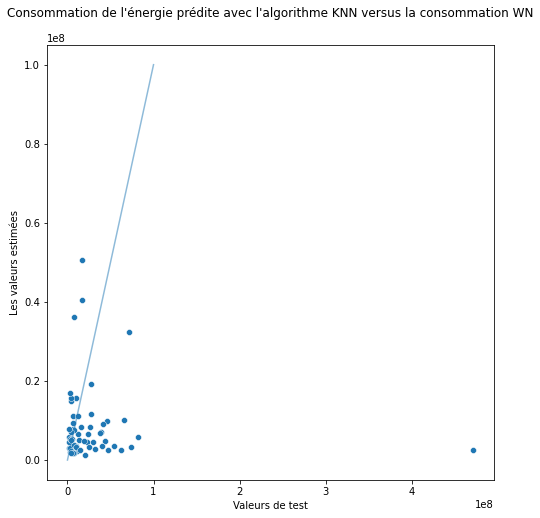

In [36]:
plt.figure(figsize=(8,8))
sns.lineplot(x = [0,1e8], y = [0,1e8], alpha=0.5)
sns.scatterplot(Y_testexp["SiteEnergyUseWN(kBtu)_log"],energy_knn["predic"])
plt.title('Consommation de l\'énergie prédite avec l\'algorithme KNN versus la consommation WN',y=1.05)
plt.xlabel('Valeurs de test')
plt.ylabel('Les valeurs estimées')

## Lasso

In [37]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1).fit(X_train, Y_train)
start_time = timeit.default_timer()

YpredLasso = lasso.predict(X_test)
elapsedLasso = timeit.default_timer() - start_time

meanErrorLasso = mean_absolute_error(Y_test, YpredLasso).round(3)
medianErrorLasso = mean_squared_error(Y_test, YpredLasso).round(3)
rmseLasso = np.sqrt(medianErrorLasso).round(3)
r2score = r2_score(Y_test,YpredLasso).round(3)


print("MAE LASSO: {}".format(meanErrorLasso))
print("MSE LASSO: {}".format(medianErrorLasso))
print("RMSE LASSO: {}".format(rmseLasso))
print("R2 SCORE LASSO: {}".format(r2score))

MAE LASSO: 0.662
MSE LASSO: 0.734
RMSE LASSO: 0.857
R2 SCORE LASSO: 0.405


In [38]:
df_lasso=pd.DataFrame(np.exp(YpredLasso),columns=['predic'])

Text(0, 0.5, 'Les valeurs estimées')

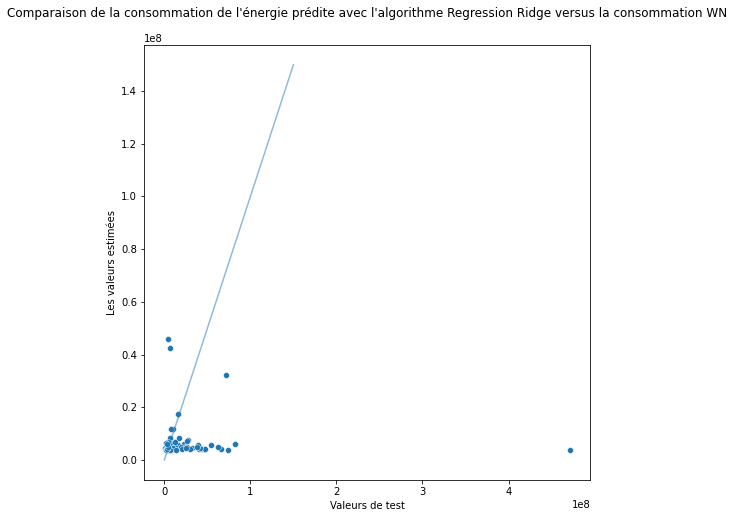

In [39]:
plt.figure(figsize=(8,8))
sns.lineplot(x = [0,1.5e8], y = [0,1.5e8], alpha=0.5)
sns.scatterplot(Y_testexp["SiteEnergyUseWN(kBtu)_log"], df_lasso['predic'])
plt.title('Comparaison de la consommation de l\'énergie prédite avec l\'algorithme Regression Ridge versus la consommation WN', y=1.05)
plt.xlabel('Valeurs de test')
plt.ylabel('Les valeurs estimées')

### Régression Ridge

In [40]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1).fit(X_train, Y_train)

start_time = timeit.default_timer()
ridge.fit(X_train, Y_train)

YpredRidge = ridge.predict(X_test)
elapsedRidge = timeit.default_timer() - start_time

meanErrorRidge = mean_absolute_error(Y_test, YpredRidge).round(3)
medianErrorRidge = mean_squared_error(Y_test, YpredRidge).round(3)
rmseRidge = np.sqrt(medianErrorRidge).round(3)
r2score = r2_score(Y_test,YpredRidge).round(3)

print("MAE Ridge: {}".format(meanErrorRidge))
print("MSE Ridge: {}".format(medianErrorRidge))
print("RMSE Ridge: {}".format(rmseRidge))
print("R2 SCORE Ridge est: {}".format(r2score))

MAE Ridge: 0.543
MSE Ridge: 0.646
RMSE Ridge: 0.804
R2 SCORE Ridge est: 0.477


In [41]:
df_ridge=pd.DataFrame(np.exp(YpredRidge),columns=['predic'])

Text(0, 0.5, 'Les valeurs estimées')

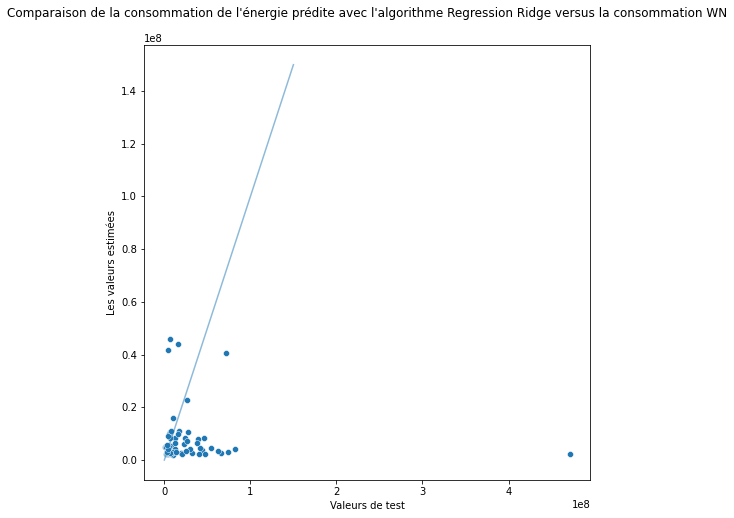

In [42]:
plt.figure(figsize=(8,8))
sns.lineplot(x = [0,1.5e8], y = [0,1.5e8], alpha=0.5)
sns.scatterplot(Y_testexp["SiteEnergyUseWN(kBtu)_log"], df_ridge['predic'])
plt.title('Comparaison de la consommation de l\'énergie prédite avec l\'algorithme Regression Ridge versus la consommation WN', y=1.05)
plt.xlabel('Valeurs de test')
plt.ylabel('Les valeurs estimées')

### DecisionTreeRegressor

In [43]:
from sklearn.tree import DecisionTreeRegressor

dt_reg =  DecisionTreeRegressor(random_state=42)
start_time = timeit.default_timer()
dt_reg.fit(X_train, Y_train)

YpredDecisionTreeRegressor = dt_reg.predict(X_test)
elapsedDecisionTreeRegressor= timeit.default_timer() - start_time

meanErrorDecisionTreeRegressor = mean_absolute_error(Y_test, YpredDecisionTreeRegressor).round(3)
medianErrorDecisionTreeRegressor = mean_squared_error(Y_test, YpredDecisionTreeRegressor).round(3)
rmseDecisionTreeRegressor = np.sqrt(medianErrorDecisionTreeRegressor).round(3)
r2score = r2_score(Y_test,YpredDecisionTreeRegressor).round(3)

print("MAE Ridge: {}".format(meanErrorDecisionTreeRegressor))
print("MSE Ridge: {}".format(medianErrorDecisionTreeRegressor))
print("RMSE Ridge: {}".format(rmseDecisionTreeRegressor))
print("R2 SCORE Ridge est: {}".format(r2score))



MAE Ridge: 0.562
MSE Ridge: 0.567
RMSE Ridge: 0.753
R2 SCORE Ridge est: 0.54


In [44]:
df_dt_reg=pd.DataFrame(np.exp(YpredDecisionTreeRegressor),columns=['predic'])

Text(0, 0.5, 'Les valeurs estimées')

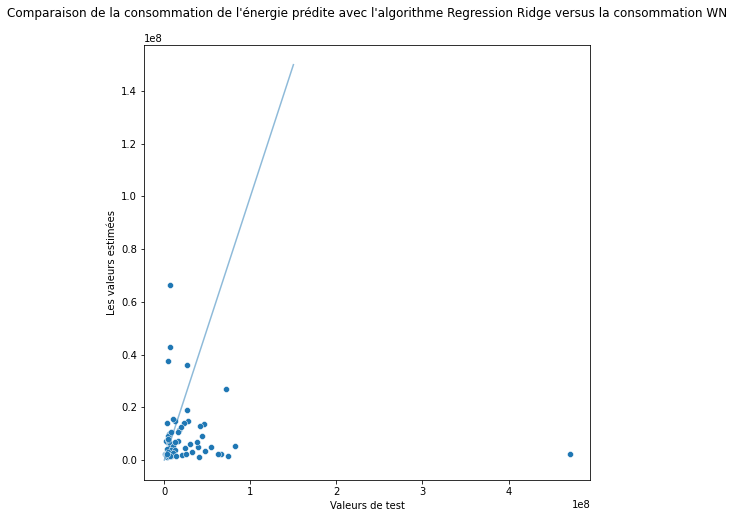

In [45]:
plt.figure(figsize=(8,8))
sns.lineplot(x = [0,1.5e8], y = [0,1.5e8], alpha=0.5)
sns.scatterplot(Y_testexp["SiteEnergyUseWN(kBtu)_log"], df_dt_reg['predic'])
plt.title('Comparaison de la consommation de l\'énergie prédite avec l\'algorithme Regression Ridge versus la consommation WN', y=1.05)
plt.xlabel('Valeurs de test')
plt.ylabel('Les valeurs estimées')

La on vas créer une boucle qui parcours tous les modèles du dictionnaire et qui enregistre les résultats dans une dataframe en utilisant une cross validation. Et de cette façon, le processus sera plus facile.



In [46]:
# examiner différents modèles de régression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso,Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

dummy_reg = DummyRegressor(strategy="median")
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
neigh = KNeighborsRegressor(n_neighbors=3)

In [47]:
#Les modèles sans paramètre spécifique
#MAE, MSE, RMSE, R²
model = [dummy_reg, lasso, ridge,  dt_reg, svm_reg, ridge_kernel, adaboost, rdmforest, gdboost,  neigh]
dict_model = {}

for model in model:
    model.fit(X_train, Y_train)
    start_time = timeit.default_timer()
    Y_pred = model.predict(X_test)
    time = timeit.default_timer() - start_time
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(Y_test, Y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score, time)

results = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²","time"])
results.columns = ["Dummy Regressor", "Lasso", "Ridge", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost","Random Forest", "GradientBoosting", "KNN"]

results

,Dummy Regressor,Lasso,Ridge,DecisionTree,SVM,Ridge Kernel,AdaBoost,Random Forest,GradientBoosting,KNN
MAE,0.878000,0.886000,0.541000,0.562000,0.443000,0.540000,0.542000,0.435000,0.448000,0.521000
MSE,1.237000,1.234000,0.643000,0.567000,0.371000,0.630000,0.438000,0.326000,0.353000,0.485000
RMSE,1.112000,1.111000,0.802000,0.753000,0.609000,0.794000,0.661000,0.571000,0.595000,0.697000
R²,-0.003000,-0.000000,0.479000,0.540000,0.699000,0.489000,0.645000,0.735000,0.713000,0.606000
time,0.000044,0.001099,0.000295,0.000366,0.041353,0.002813,0.007345,0.013176,0.000701,0.004401


In [48]:
results_t=results.transpose()

In [49]:
results_t.reset_index(inplace=True)

In [50]:
results_t.rename(columns={"index": "Nom de Model"},inplace=True)

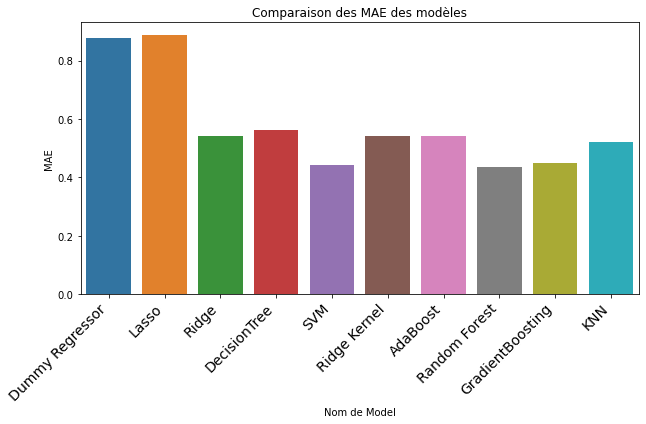

In [51]:
plt.figure(figsize=(10,5))
plt.title('Comparaison des MAE des modèles')
ax = sns.barplot(x = results_t['Nom de Model'], y = results_t['MAE'])
ax.set_xticklabels(labels = results_t['Nom de Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

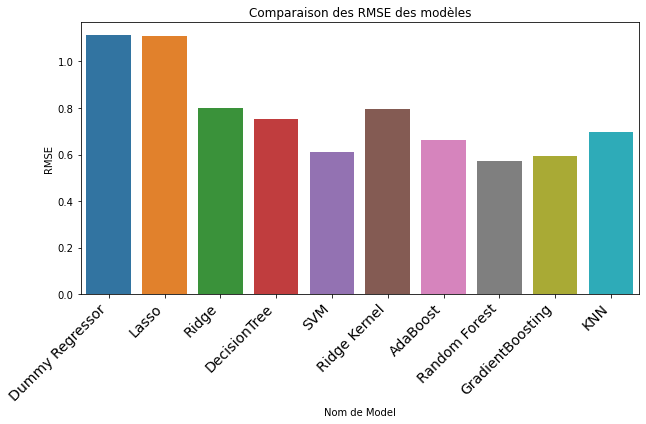

In [52]:
plt.figure(figsize=(10,5))
plt.title('Comparaison des RMSE des modèles')
ax = sns.barplot(x = results_t['Nom de Model'], y = results_t['RMSE'])
ax.set_xticklabels(labels = results_t['Nom de Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

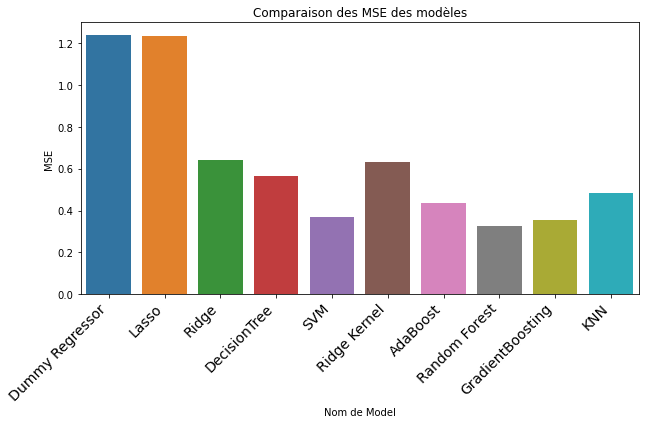

In [53]:
plt.figure(figsize=(10,5))
plt.title('Comparaison des MSE des modèles')
ax = sns.barplot(x = results_t['Nom de Model'], y = results_t['MSE'])
ax.set_xticklabels(labels = results_t['Nom de Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

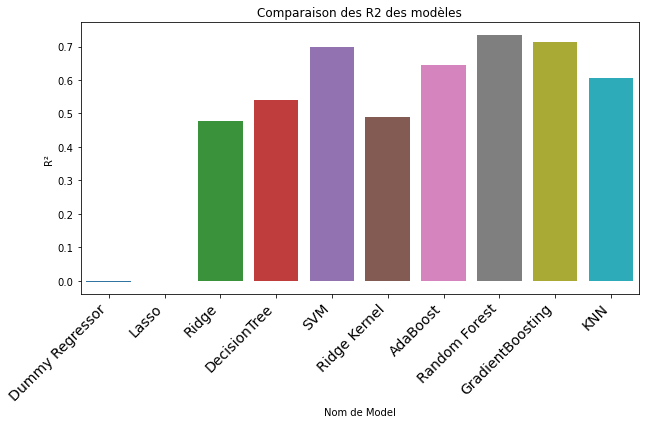

In [54]:
plt.figure(figsize=(10,5))
plt.title('Comparaison des R2 des modèles')
ax = sns.barplot(x = results_t['Nom de Model'], y = results_t['R²'])
ax.set_xticklabels(labels = results_t['Nom de Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

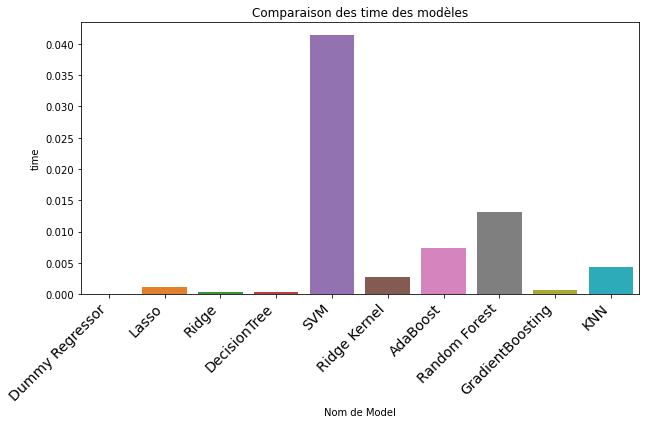

In [55]:
plt.figure(figsize=(10,5))
plt.title('Comparaison des time des modèles')
ax = sns.barplot(x = results_t['Nom de Model'], y = results_t['time'])
ax.set_xticklabels(labels = results_t['Nom de Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

On voit que la valeur R2 de l'algorithme Random Forest et GradientBoosting sont tres élevée, mais quand on regarde le temps d'exécution, pour Random Forest cette valeur est aussi très longue. On va examiner GradientBoosting et Random forest, aussi on va examiner ces deux algorithmes en optimisant les paramètres pour une meilleure compréhension.

## Recherche des  meilleurs hyperparamètres et des models

### GradientBoosting Regressor

In [59]:
from scipy.stats import loguniform
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

gb_params = {"n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
             "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
             "learning_rate" : [0.001, 0.01, 0.1, 0.2, 0,3],
             "max_depth": [6, 10, 15, 20],
             }

gdboost = GradientBoostingRegressor(random_state=42)

gb_cv_model = GridSearchCV(gdboost,
                           gb_params,
                           cv=5,
                           n_jobs = 2,
                          scoring="neg_mean_squared_error")

gb_cv_model.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=2,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3],
                         'max_depth': [6, 10, 15, 20],
                         'max_leaf_nodes': [2, 5, 10, 20, 50, 100],
                         'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500]},
             scoring='neg_mean_squared_error')

In [60]:
gb_cv_model.best_params_

{'learning_rate': 0.2,
 'max_depth': 6,
 'max_leaf_nodes': 5,
 'n_estimators': 100}

In [61]:
gb_cv_model_tuned =  GradientBoostingRegressor(learning_rate = 0.2, 
                                               max_depth = 6, 
                                               max_leaf_nodes = 5,
                                               n_estimators = 100)

In [62]:
gb_cv_model_tuned.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=6, max_leaf_nodes=5)

In [63]:
YpredGradientBoostingRegressor = gb_cv_model_tuned.predict(X_test)

In [64]:
start_time = timeit.default_timer()
YpredGradientBoostingRegressor = gb_cv_model_tuned.predict(X_test)
elapsedGradientBoostingRegressor= timeit.default_timer() - start_time
meanErrorGradientBoostingRegressor = mean_absolute_error(Y_test, YpredGradientBoostingRegressor).round(3)
medianErrorGradientBoostingRegressor= mean_squared_error(Y_test, YpredGradientBoostingRegressor).round(3)
rmseGradientBoostingRegressor = np.sqrt(medianErrorGradientBoostingRegressor).round(3)
r2score = r2_score(Y_test,YpredGradientBoostingRegressor).round(3)

print("MAE GradientBoostingRegressor: {}".format(meanErrorGradientBoostingRegressor))
print("MSE GradientBoostingRegressor: {}".format(medianErrorGradientBoostingRegressor))
print("RMSE GradientBoostingRegressor: {}".format(rmseGradientBoostingRegressor))
print("R2 SCORE GradientBoostingRegressor : {}".format(r2score))
print("time GradientBoostingRegressor : {}".format(elapsedGradientBoostingRegressor))

MAE GradientBoostingRegressor: 0.428
MSE GradientBoostingRegressor: 0.326
RMSE GradientBoostingRegressor: 0.571
R2 SCORE GradientBoostingRegressor : 0.736
time GradientBoostingRegressor : 0.0020893129999421944


### RandomForest Regressor

In [65]:
from scipy.stats import loguniform
from sklearn.model_selection import GridSearchCV
from sklearn.tree import RandomForestRegressor

rf_params = {'max_features' : [3,5,10,15],
             'max_depth': [5, 15, 25, 50],
             'n_estimators': [100,200,500,1000,2000],
            }

rdmforest = RandomForestRegressor(random_state=42)

rf_cv_model = GridSearchCV(rdmforest,
                           rf_params,
                           cv=5,
                           n_jobs = 2,
                          scoring="neg_mean_squared_error")

rf_cv_model.fit(X_train, Y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=2,
             param_grid={'max_depth': [5, 15, 25, 50],
                         'max_features': [3, 5, 10, 15],
                         'n_estimators': [100, 200, 500, 1000, 2000]},
             scoring='neg_mean_squared_error')

In [66]:
rf_cv_model.best_params_

{'max_depth': 15, 'max_features': 15, 'n_estimators': 1000}

In [67]:
rdmforest_tuned =  RandomForestRegressor(max_depth= 15, 
                                         max_features= 15, 
                                         n_estimators= 1000)

In [68]:
rdmforest_tuned.fit(X_train, Y_train)

RandomForestRegressor(max_depth=15, max_features=15, n_estimators=1000)

In [69]:
YpredRandomForestRegressor = rdmforest_tuned.predict(X_test)

In [70]:
start_time = timeit.default_timer()
YpredRandomForestRegressor = rdmforest_tuned.predict(X_test)
elapsedRandomForestRegressor= timeit.default_timer() - start_time
meanErrorRandomForestRegressor = mean_absolute_error(Y_test, YpredRandomForestRegressor).round(3)
medianErrorRandomForestRegressor = mean_squared_error(Y_test, YpredRandomForestRegressor).round(3)
rmseRandomForestRegressor = np.sqrt(medianErrorRandomForestRegressor).round(3)
r2score = r2_score(Y_test,YpredRandomForestRegressor).round(3)

print("MAE RandomForestRegressor: {}".format(meanErrorRandomForestRegressor))
print("MSE RandomForestRegressor: {}".format(medianErrorRandomForestRegressor))
print("RMSE RandomForestRegressor: {}".format(rmseRandomForestRegressor))
print("R2 SCORE RandomForestRegressor est: {}".format(r2score))
print("time RandomForestRegressor est: {}".format(elapsedRandomForestRegressor))

MAE RandomForestRegressor: 0.444
MSE RandomForestRegressor: 0.344
RMSE RandomForestRegressor: 0.587
R2 SCORE RandomForestRegressor est: 0.721
time RandomForestRegressor est: 0.13266711100004613


In [71]:
model = [rdmforest_tuned, gb_cv_model_tuned]
dict_results = {}

for model in model:
    model.fit(X_train, Y_train)
    start_time = timeit.default_timer()
    Y_pred = model.predict(X_test)
    time = timeit.default_timer() - start_time
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(Y_test, Y_pred, multioutput="variance_weighted").round(3)
    dict_results[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score, time)

results_gb_et_rf = pd.DataFrame(dict_results, index=["MAE", "MSE", "RMSE", "R²","time"])
results_gb_et_rf.columns = ["Random Forest", "GradientBoosting"]

results_gb_et_rf



,Random Forest,GradientBoosting
MAE,0.446000,0.427000
MSE,0.347000,0.325000
RMSE,0.589000,0.570000
R²,0.719000,0.736000
time,0.140761,0.000667


In [72]:
results_gb_et_rf_t=results_gb_et_rf.transpose()

In [73]:
results_gb_et_rf_t.reset_index(inplace=True)

In [74]:
results_gb_et_rf_t.rename(columns={"index": "Nom de Model"},inplace=True)

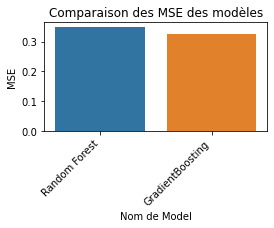

In [75]:
plt.figure(figsize=(4,2))
plt.title('Comparaison des MSE des modèles')
ax = sns.barplot(x = results_gb_et_rf_t['Nom de Model'], y = results_gb_et_rf_t['MSE'])
ax.set_xticklabels(labels = results_gb_et_rf_t['Nom de Model'], rotation=45, horizontalalignment='right',size=10)
plt.show()

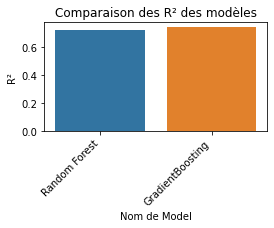

In [76]:
plt.figure(figsize=(4,2))
plt.title('Comparaison des R² des modèles')
ax = sns.barplot(x = results_gb_et_rf_t['Nom de Model'], y = results_gb_et_rf_t['R²'])
ax.set_xticklabels(labels = results_gb_et_rf_t['Nom de Model'], rotation=45, horizontalalignment='right',size=10)
plt.show()

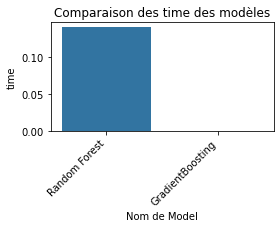

In [77]:
plt.figure(figsize=(4,2))
plt.title('Comparaison des time des modèles')
ax = sns.barplot(x = results_gb_et_rf_t['Nom de Model'], y = results_gb_et_rf_t['time'])
ax.set_xticklabels(labels = results_gb_et_rf_t['Nom de Model'], rotation=45, horizontalalignment='right',size=10)
plt.show()

### Model Selectionne

In [78]:
model_selectionne=GradientBoostingRegressor(learning_rate = 0.2, 
                                            max_depth = 6, 
                                            max_leaf_nodes = 5,
                                            n_estimators = 100)

In [79]:
model_selectionne.fit(X_train,Y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=6, max_leaf_nodes=5)

In [80]:
Y_pred= model_selectionne.predict(X_test)
reg_met(np.array(Y_test), Y_pred)

MAE:  0.43111
MSE:  0.33157
RMSE:  0.5758197600562731
MAPE:  0.02777
R²:  0.73113


Text(0, 0.5, 'Les valeurs estimées')

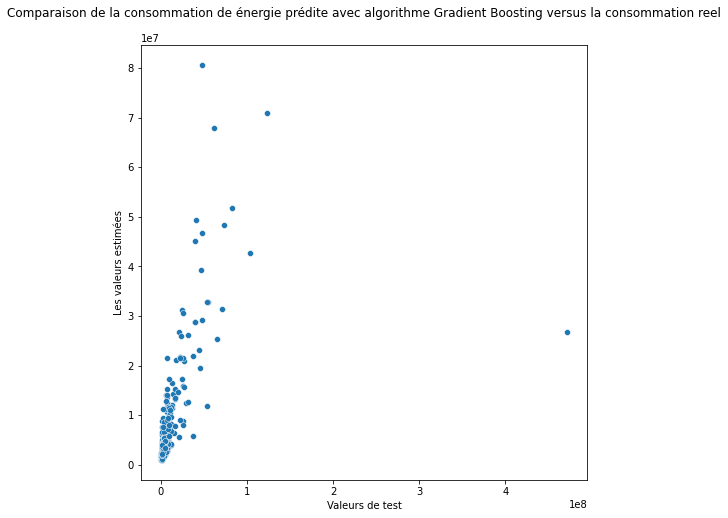

In [81]:
plt.figure(figsize=(8,8))
sns.scatterplot(np.exp(Y_test["SiteEnergyUseWN(kBtu)_log"]), np.exp(Y_pred))
plt.title('Comparaison de la consommation de énergie prédite avec algorithme Gradient Boosting versus la consommation reel', y=1.05)
plt.xlabel('Valeurs de test')
plt.ylabel('Les valeurs estimées')

### Feature_importance

In [82]:
feature_importance = model_selectionne.feature_importances_

In [83]:
fi = preprocessor.get_params()['transformers']
feature_names = []
for name,transformer,features in fi:
    try:
        Var = preprocessor.named_transformers_[name].get_feature_names().tolist()
    except AttributeError:
        Var = features
    feature_names = feature_names + Var

feature_names

['x0_Campus',
 'x0_NonResidential',
 'x0_Nonresidential COS',
 'x0_SPS-District K-12',
 'x1_Distribution Center',
 'x1_Hospital',
 'x1_Hotel',
 'x1_K-12 School',
 'x1_Laboratory',
 'x1_Large Office',
 'x1_Medical Office',
 'x1_Mixed Use Property',
 'x1_Other',
 'x1_Refrigerated Warehouse',
 'x1_Residence Hall',
 'x1_Restaurant',
 'x1_Retail Store',
 'x1_Self-Storage Facility',
 'x1_Senior Care Community',
 'x1_Small- and Mid-Sized Office',
 'x1_Supermarket / Grocery Store',
 'x1_University',
 'x1_Warehouse',
 'x1_Worship Facility',
 'x2_BALLARD',
 'x2_CENTRAL',
 'x2_DELRIDGE',
 'x2_DOWNTOWN',
 'x2_EAST',
 'x2_GREATER DUWAMISH',
 'x2_LAKE UNION',
 'x2_MAGNOLIA / QUEEN ANNE',
 'x2_NORTH',
 'x2_NORTHEAST',
 'x2_NORTHWEST',
 'x2_SOUTHEAST',
 'x2_SOUTHWEST',
 'x3_Adult Education',
 'x3_Automobile Dealership',
 'x3_College/University',
 'x3_Courthouse',
 'x3_Data Center',
 'x3_Distribution Center',
 'x3_Financial Office',
 'x3_Fire Station',
 'x3_Fitness Center/Health Club/Gym',
 'x3_Hospita

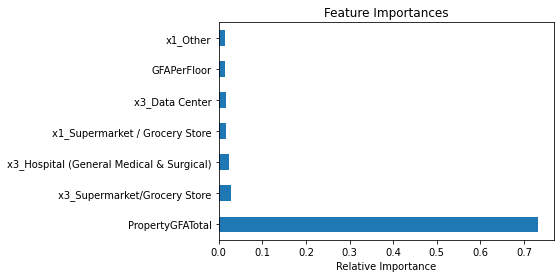

In [84]:
features_importances = pd.Series(feature_importance,index=feature_names)
features_importances.nlargest(7).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

### L'effet du score ENERGY STAR

In [85]:
#Ajout de la variable à nos variables X
X['energystar_score'] = energystar_score
#Ajout de la variable dans les variables numérique du preprocessor
numeric_features.append('energystar_score')

In [86]:
#Filtrage des données ayant un Energy Star Score renseigné
X = X[X['energystar_score'].isnull()==False]
Y_star = Y[Y.index.isin(list(X.index))]

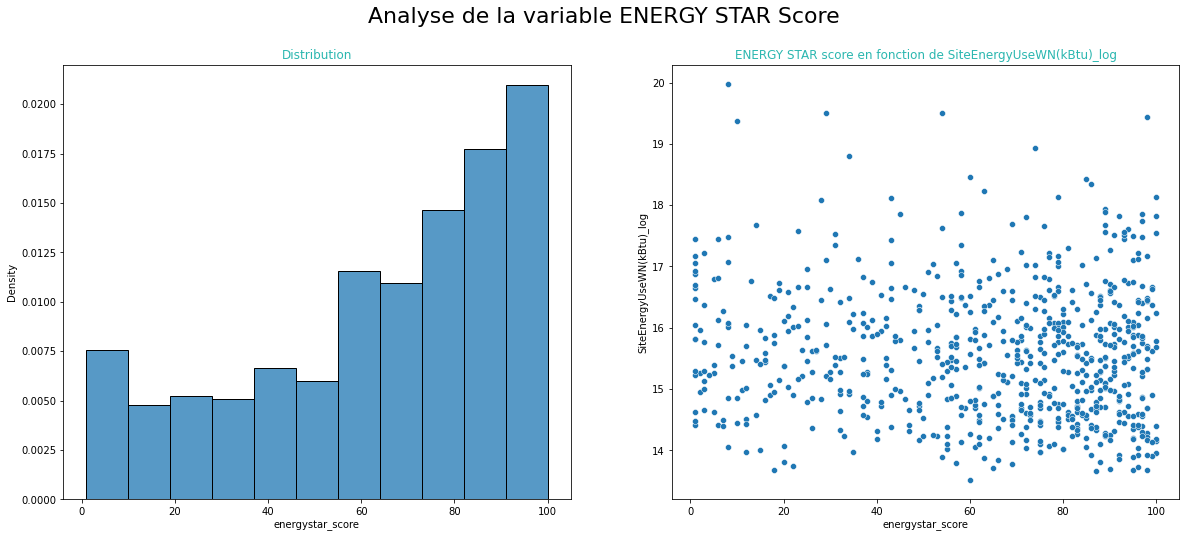

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=X, x='energystar_score', stat="density", ax=axes[0])
axes[0].set_title("Distribution", color='#2cb7b0')
sns.scatterplot(data=pd.concat([X,Y], axis=1), y=data_filter['SiteEnergyUseWN(kBtu)_log'], x='energystar_score', ax=axes[1])
axes[1].set_title("ENERGY STAR score en fonction de SiteEnergyUseWN(kBtu)_log", color='#2cb7b0')
plt.suptitle("Analyse de la variable ENERGY STAR Score", fontsize=22)
plt.show()

In [88]:
X_train, X_test, Y_star_train, Y_star_test = train_test_split(X, Y_star, test_size=0.25, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 540 lignes,
Test: 181 lignes.



In [89]:
# transformation des variables
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [90]:
model_selectionne.fit(X_train,Y_star_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=6, max_leaf_nodes=5)

In [91]:
Y_star_pred= model_selectionne.predict(X_test)
reg_met(np.array(Y_star_test), Y_star_pred)

MAE:  0.29396
MSE:  0.18344
RMSE:  0.4282990519386477
MAPE:  0.01871
R²:  0.8283


Text(0, 0.5, 'Les valeurs estimées')

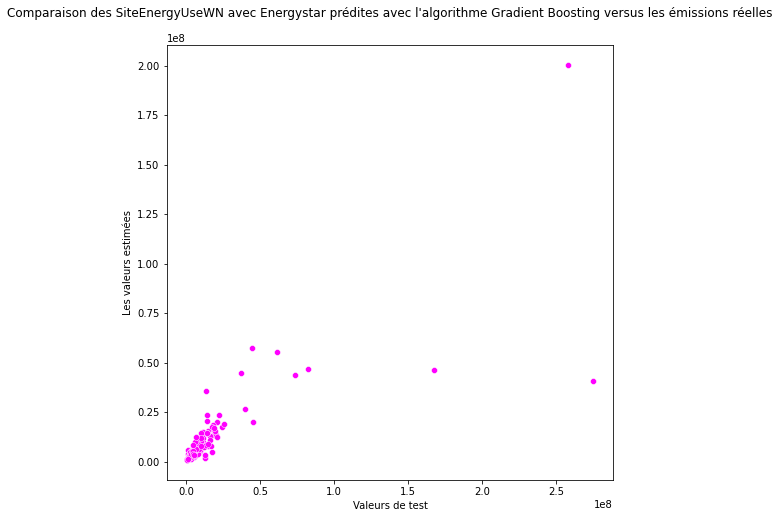

In [92]:
plt.figure(figsize=(8,8))
sns.scatterplot(np.exp(Y_star_test["SiteEnergyUseWN(kBtu)_log"]), np.exp(Y_star_pred), color='magenta')
plt.title('Comparaison des SiteEnergyUseWN avec Energystar prédites avec l\'algorithme Gradient Boosting versus les émissions réelles',y=1.05)
plt.xlabel('Valeurs de test')
plt.ylabel('Les valeurs estimées')